## Abstract

For this project, we aim to build and evaluate a recommender system using the Amazon Books Reviews dataset from Kaggle : <Link Text>https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews <br><br>
The primary objective is to develop a recommendation pipeline that can suggest relevant books to users, with a specific focus on fiction books. For the book recommendation system, we fired refine the dataset and then implemented two different approaches:
The first approach leverages the **Apriori algorithm** to uncover strong association rules between books based on co-rating patterns. This method is transparent and easy to interpret but struggles with accuracy due to data sparsity and limited depth in user preference modeling.

The second approach utilizes an **Autoencoder**, a type of neural network for unsupervised learning. The autoencoder compresses the user-item interaction matrix into a lower-dimensional latent space and reconstructs it to predict missing values. This method captures complex patterns in user behavior and delivers significantly better recommendation performance. However, it lacks interpretability, making it difficult to explain individual recommendations.

In conclusion, the Apriori algorithm offers explainable but less effective recommendations, while the autoencoder provides more accurate results at the cost of model transparency.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import random
from rapidfuzz import process, fuzz
import re

## Data Preprocessing

### Dataset
The Dataset Books_rating.csv and books_data.csv can be downloaded from kaggle:  
<Link Text>https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews <br><br>
This dataset includes two files:

**1. Books_rating.csv:** contains user ratings of books. This file has information about 3M book reviews for 212404 unique book and users who gives these reviews for each book.

**2. books_data.csv:** includes metadata of  of 212404 books such as genres, authors, cover, description and etc.

### Process
![Kaggle Logo](https://i.imgur.com/9ELRD7G.png)

Both datasets share a common key: Title. To prepare the data for building a recommender system, we first merged the two datasets on this key. This allowed us to enrich each rating with relevant book metadata such as author and category. Then we reformed the dataframe with only the neccessary columns for the process which are Title, User_id, review/score, authors and categories.

We then filtered the data to include only fiction books, since our recommendation system focuses specifically on this genre.

Next, we removed all the null values. Then we cleaned the book titles by removing any content within parentheses. These often contain edition or publisher details that are not essential for the recommendation task and can introduce noise (e.g., “Slaughterhouse-Five (Modern Library Edition)” vs. “Slaughterhouse-Five”). 

To further reduce duplication, we used the rapidfuzz library to identify and unify slightly varied versions of the same title. We ensured that matched titles also had the same author, which helped increase the confidence that these entries refer to the same book. For example, several variations of “Slaughterhouse-Five” existed in the dataset due to differences in punctuation, casing, or subtitles; these were standardized under a single canonical title.

then from the canonical titled dataset, we first filtered out books with fewer than 50 ratings to focus on titles with sufficient user interaction. Then, we filtered users who rated more than 20 books to ensure we included only active users with meaningful preferences. By keeping only frequently rated books and active users, we ensure the model has enough data to learn meaningful patterns, resulting in more accurate and reliable recommendations.

This preprocessing step was essential to reduce redundancy and ensure cleaner input for both recommendation models.


In [5]:
random.seed(42)
np.random.seed(42)

### Loading the Data

In [6]:
ratings_df = pd.read_csv('Books_rating.csv')
books_df = pd.read_csv('books_data.csv')

In [7]:
print(ratings_df.head())
print(books_df.head())

           Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   

                          profileName review/helpfulness  review/score  \
0               Jim of Oz "jim-of-oz"                7/7           4.0   
1                       Kevin Killian              10/10           5.0   
2                        John Granger              10/11           5.0   
3  Roy E. Perry "amateur philosopher"                7/7           4.0   
4     D. H. Richards "ninthwavestore"                3/3           4.0   

   review/time                                   review/summary  \
0    940636800           Nice collection of Julie Strai

### Merge Datasets on "Title" key

In [8]:
#merge the categories and authors columns with the ratings_df
df = pd.merge(ratings_df, books_df[['Title', 'categories', 'authors']], on='Title', how='left')
print(df.head())

           Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   

                          profileName review/helpfulness  review/score  \
0               Jim of Oz "jim-of-oz"                7/7           4.0   
1                       Kevin Killian              10/10           5.0   
2                        John Granger              10/11           5.0   
3  Roy E. Perry "amateur philosopher"                7/7           4.0   
4     D. H. Richards "ninthwavestore"                3/3           4.0   

   review/time                                   review/summary  \
0    940636800           Nice collection of Julie Strai

In [ ]:
#make smaller dataframe with only the columns we need
df = df.loc[:,['Title','User_id','review/score','authors','categories']]
#Choosing only fictions for recommendation
df = df[df['categories'] == "['Fiction']"]
df.count()

Title           824439
User_id         657511
review/score    824439
authors         824028
categories      824439
dtype: int64

In [11]:
#remove na values
print(df.isna().sum())
df = df.dropna()
df.shape

Title                0
User_id         166928
review/score         0
authors            411
categories           0
dtype: int64


(657190, 5)

### Title Standardization with RapidFuzz

In [34]:
#get rid of parentheses in book titles
df['Title'] = df.loc[:,'Title'].str.replace(r"\s*\(.*?\)", "", regex=True)
df.head()

,Title,User_id,review/score,authors,categories
14,Whispers of the Wicked Saints,A3Q12RK71N74LB,1.0,['Veronica Haddon'],['Fiction']
15,Whispers of the Wicked Saints,A1E9M6APK30ZAU,4.0,['Veronica Haddon'],['Fiction']
16,Whispers of the Wicked Saints,AUR0VA5H0C66C,1.0,['Veronica Haddon'],['Fiction']
17,Whispers of the Wicked Saints,A1YLDZ3VHR6QPZ,5.0,['Veronica Haddon'],['Fiction']
18,Whispers of the Wicked Saints,ACO23CG8K8T77,5.0,['Veronica Haddon'],['Fiction']


In [12]:
#replace different titles for the same books with a single title.
#!!! This code block was generated by chatGPT !!!

unique_titles = df['Title'].unique()
canonical_map = {}

for title in unique_titles:
    #checks if this title is already the offical accepted spelling/punctuation of the title
    if title in canonical_map:
        continue
    #finds other titles similar to the current title
    matches = process.extract(title, unique_titles, scorer=fuzz.token_sort_ratio, score_cutoff=0.85)
    for match, score, _ in matches:
        #if the similarity is high enough, maps the matching title to the accepted official title
        canonical_map[match] = title

# Step 3: Replace titles using the mapping
df['Title'] = df['Title'].map(canonical_map)

In [14]:
#remove duplicate ratings
df.drop_duplicates(subset=['User_id','Title'], keep='first', inplace=True)
df.shape

(491821, 5)

In [15]:
#see number of unique uesers and titles. We need make these a more manageable size
print(df['Title'].unique().size)
print(df['User_id'].unique().size)

8454
268646


### Filtering Based on Ratings and User Activity

Many books in the dataset have only a handful of ratings. Such sparse data isn’t useful for collaborative filtering or pattern learning.
Filtering to books with more than 50 ratings ensures:
1. These books are popular enough.
2. There’s enough data to learn reliable patterns.
Result: 2,150 books remain, rated 393,216 times.

In [21]:
book_rating_counts = df['Title'].value_counts()
books_with_ratings = book_rating_counts[book_rating_counts > 50].index
filtered_df = df[df['Title'].isin(books_with_ratings)]
print(filtered_df.shape)
print(f"users: {filtered_df['User_id'].unique().size}")
print(f"books: {filtered_df['Title'].unique().size}")
print(f'matrix dimensions{filtered_df.shape}')

(393216, 5)
users: 223226
books: 2150
matrix dimensions(393216, 5)


Many users rate only a few books — too little data to determine their preferences. Filtering to users who rated more than 20 books ensures:
1. The recommender has enough history to make meaningful suggestions.
2. Reduces noise from inactive users. Result: 1,066 active users remain, with 45,686 ratings.

In [23]:
user_rating_counts = filtered_df['User_id'].value_counts()
users_with_ratings = user_rating_counts[user_rating_counts > 20].index
filtered_df = filtered_df[filtered_df['User_id'].isin(users_with_ratings)]
print(filtered_df.shape)
print(f"users: {filtered_df['User_id'].unique().size}")
print(f"books: {filtered_df['Title'].unique().size}")
print(f"matrix dimensions{filtered_df.shape}")

(45686, 5)
users: 1066
books: 2135
matrix dimensions(45686, 5)


In [24]:
df_pivot = filtered_df.pivot_table(index='User_id', columns='Title', values='review/score', aggfunc = 'max')
df_pivot.head()

Title,"""Chosen"" Classics: Round the World in Eighty Days","""D"" is for Deadbeat","""Mildred Pierce","""Ra Force Rising"": Brother G","""Thirty years in hell""; or, ""From darkness to light",'Tis The Season: The Choice\First Fruits\A New Year; A New Beginning,'Tis the Season to Be Murdered,... Summer moonshine,...Arrow pointing nowhere,1 Ragged Ridge Road,...,Zane's Gettin' Buck Wild: Sex Chronicles II,Zane's Skyscraper: A Novel,Zazie dans le Mtro,Zen Attitude,Zia,Zorba the Greek,green valley,never too much,our davie pepper,the Picture of Dorian Gray
User_id,,,,,,,,,,,,,,,,,,,,,
A106016KSI0YQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A106E1N0ZQ4D9W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10T0OW97SFBB,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10Y3OZWENAQ6W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1129LM24YWSZV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Save the pivot table with all ratings to csv

In [25]:
df_pivot.to_csv('ratings_matrix.csv')

#### Save the basic metadata for the subset of books we are using

In [26]:
filtered_df.to_csv('filtered_ratings.csv')

# Visualizations

This heatmap visualization represents a 50x50 slice of our user-item matrix — specifically, 50 users vs. 50 books from df_pivot.

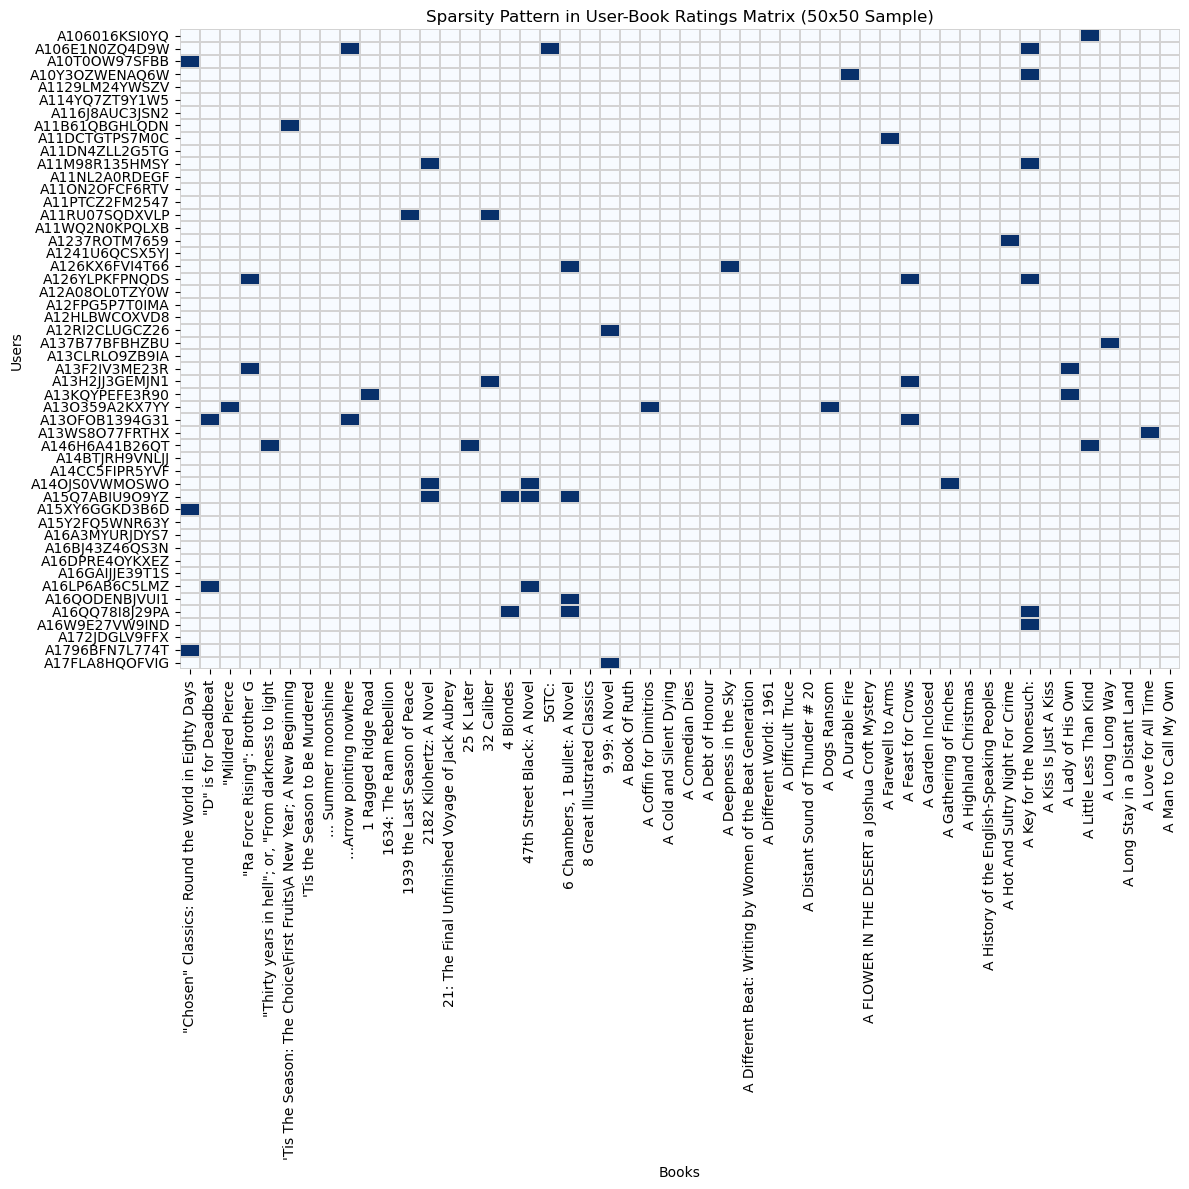

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
# Show a smaller sample for visualization (e.g., first 50 users and 50 books)
sample = df_pivot.iloc[:50, :50]

# Plot the heatmap showing where data is present (non-NaN)
plt.figure(figsize=(12, 12))
sns.heatmap(sample.notna(), 
            cbar=False, 
            cmap='Blues', 
            linewidths=0.1, 
            linecolor='lightgrey')

plt.title('Sparsity Pattern in User-Book Ratings Matrix (50x50 Sample)')
plt.xlabel('Books')
plt.ylabel('Users')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [60]:
sparsity = 1.0 - (df_pivot.count().sum() / (df_pivot.shape[0] * df_pivot.shape[1]))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 97.99%


Sparsity 97.99% means that only a small fraction of all possible user-book combinations have been rated. Hence, the dataset is highly sparse, meaning most users have interacted with only a few books. This is why we use models capable of learning from limited data like autoencoders.

### Top 10 most rated Books

C:\Users\zafri\AppData\Local\Temp\ipykernel_20724\286377324.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=book_counts.index, x=book_counts.values, palette="viridis")


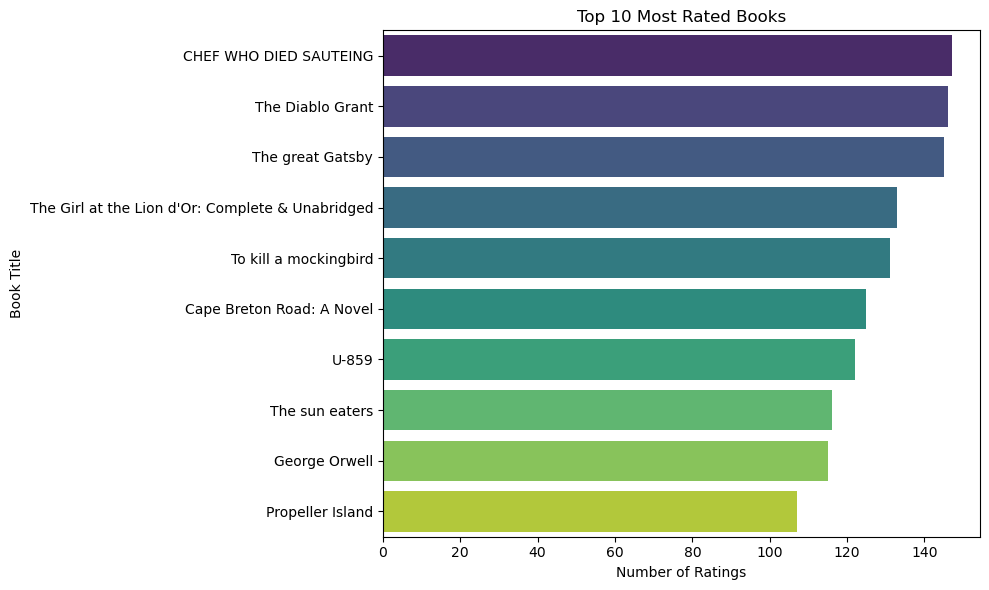

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

book_counts = filtered_df['Title'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=book_counts.index, x=book_counts.values, palette="viridis")
plt.title("Top 10 Most Rated Books")
plt.xlabel("Number of Ratings")
plt.ylabel("Book Title")
plt.tight_layout()
plt.show()


### Top 10 most Active Users

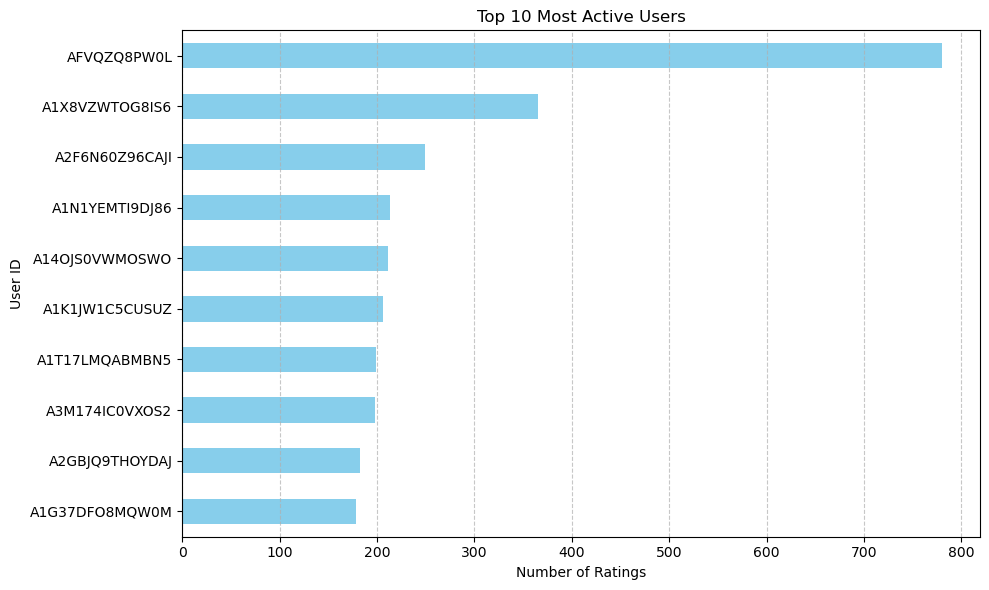

In [57]:

# Count how many books each user rated
top_users = filtered_df['User_id'].value_counts().head(10)

# Plot as a horizontal bar chart
plt.figure(figsize=(10, 6))
top_users.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('User ID')
plt.title('Top 10 Most Active Users')
plt.gca().invert_yaxis()  # Optional: highest at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
